<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 5px; height: 70px">

# Optimising Hospital Bed Occupancy through Machine Learning
**DSI-41 Group FWSG**: Muhammad Faaiz Khan, Sharifah Nurulhuda, Tan Wei Chiong, Gabriel Tan

### 03_03 Modelling: SARIMA

### Overview

The model in this section uses SARIMA with only bed occupancy rate data for NUH.

A significant difference between this section and most of the other sections is that only data from 2022 onwards is used, as 2022 is when the COVID-19 in Singapore started to be seen as endemic. This allows us to see what the predictions would be like in a post-COVID Singapore.

Here is a brief description of the model used:

|Model|What it is|What is it used for|
|---|---|---|
|SARIMA|Seasonal Auto-Regressive Integrated Moving Average|Predicting future points in a time series|

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer 
import pmdarima as pm

### Preparing data for modelling

In [2]:
final_df = pd.read_csv('../datasets/for_timeseries.csv')

In [3]:
final_df.head()

,date,year,nuh,total_rainfall,wet_bulb_temperature,dengue,urti,diarrhea,is_holiday,day_Mon,...,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,2022-01-01,2022,72.0,25.2,26.0,11.0,904.0,287.0,1,False,...,False,False,True,False,False,False,False,False,False,False
1,2022-01-02,2022,73.7,50.0,24.1,15.0,977.0,297.0,0,False,...,False,False,True,False,False,False,False,False,False,False
2,2022-01-03,2022,78.7,6.0,25.6,15.0,977.0,297.0,0,True,...,False,False,True,False,False,False,False,False,False,False
3,2022-01-04,2022,79.1,4.8,25.8,15.0,977.0,297.0,0,False,...,False,False,True,False,False,False,False,False,False,False
4,2022-01-05,2022,81.8,1.0,26.3,15.0,977.0,297.0,0,False,...,False,False,True,False,False,False,False,False,False,False


In [4]:
final_df['date'] = pd.to_datetime(final_df['date'])
final_df = final_df[final_df['date'] >= dt.datetime(2022,1,1)].copy()
for col in ['year']:
    final_df[col] = [str(num) for num in final_df[col].values.tolist()]
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  730 non-null    datetime64[ns]
 1   year                  730 non-null    object        
 2   nuh                   730 non-null    float64       
 3   total_rainfall        730 non-null    float64       
 4   wet_bulb_temperature  730 non-null    float64       
 5   dengue                730 non-null    float64       
 6   urti                  730 non-null    float64       
 7   diarrhea              730 non-null    float64       
 8   is_holiday            730 non-null    int64         
 9   day_Mon               730 non-null    bool          
 10  day_Sat               730 non-null    bool          
 11  day_Sun               730 non-null    bool          
 12  day_Thu               730 non-null    bool          
 13  day_Tue             

In [5]:
final_df.head()

,date,year,nuh,total_rainfall,wet_bulb_temperature,dengue,urti,diarrhea,is_holiday,day_Mon,...,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,2022-01-01,2022,72.0,25.2,26.0,11.0,904.0,287.0,1,False,...,False,False,True,False,False,False,False,False,False,False
1,2022-01-02,2022,73.7,50.0,24.1,15.0,977.0,297.0,0,False,...,False,False,True,False,False,False,False,False,False,False
2,2022-01-03,2022,78.7,6.0,25.6,15.0,977.0,297.0,0,True,...,False,False,True,False,False,False,False,False,False,False
3,2022-01-04,2022,79.1,4.8,25.8,15.0,977.0,297.0,0,False,...,False,False,True,False,False,False,False,False,False,False
4,2022-01-05,2022,81.8,1.0,26.3,15.0,977.0,297.0,0,False,...,False,False,True,False,False,False,False,False,False,False


Lastly, we set the `date` column as index for use in SARIMAX.

In [6]:
final_df.set_index('date', inplace=True)

### Pipeline creation

For the purposes of our project scope, we will only be modelling based on NUH hospital data.

In [7]:
# defining specific subsets of features
time_features = ['year', 'month', 'day_of_week']
event_features = ['is_holiday']
hospital_features = ['nuh']
weather_features = ['total_rainfall', 'wet_bulb_temperature']
disease_features = ['dengue', 'urti', 'diarrhea']

In [8]:
# defining the train-test split and training the pipeline

def hospital_pipe(hospital):
    '''Returns the fitted SARIMA model with `hospital` as the target variable, along with the respective train-test splits
    '''

    # remaining_hospitals = [hosp for hosp in hospital_features if hosp != hospital]

    X = final_df[weather_features + event_features + disease_features]
    y = final_df[hospital]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # defining pipelines
    preprocessor = ColumnTransformer(
        transformers = [
            ('weather_numeric', StandardScaler(), weather_features + disease_features)
        ],
        remainder = 'passthrough'
    )

    # preprocesses the X train-test variables
    # this is ignored in SARIMA
    pp_X_train = preprocessor.fit_transform(X_train)
    pp_X_test = preprocessor.transform(X_test)

    # defines a new sarimax pipeline
    # this is needed because we're fitting a pipeline for each hospital
    sarima_model = pm.AutoARIMA(start_p=1, max_p=10, 
                                d=1,          # find optimum value of d automatically
                                start_q=1, max_q=10,
                                start_P=0, max_P=10,
                                D=None,
                                start_Q=0, max_Q=10,
                                m=7,          # data repeats every 7 days
                                seasonal=True,
                                trace=True,   # Print values for each fit in the grid search
                                random_state=42,
                                maxiter=10
                               )

    # fits a SARIMA model on the respective hospital
    sarima_model.fit(y_train)

    # returns the respective train-test split and the fitted SARIMA pipe
    return (pp_X_train, pp_X_test, y_train, y_test, sarima_model)


Now we fit each model and store it in a lookup table.


In [9]:
hospital_pipes = {hospital: hospital_pipe(hospital) for hospital in hospital_features}

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=2751.890, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2754.037, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2629.450, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2671.570, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2752.114, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=2747.258, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=2589.507, Time=0.15 sec
 ARIMA(1,1,0)(3,0,0)[7] intercept   : AIC=2550.954, Time=0.37 sec
 ARIMA(1,1,0)(4,0,0)[7] intercept   : AIC=2523.139, Time=0.78 sec
 ARIMA(1,1,0)(5,0,0)[7] intercept   : AIC=2515.887, Time=1.57 sec
 ARIMA(1,1,0)(6,0,0)[7] intercept   : AIC=inf, Time=2.58 sec
 ARIMA(1,1,0)(5,0,1)[7] intercept   : AIC=2506.882, Time=1.76 sec
 ARIMA(1,1,0)(4,0,1)[7] intercept   : AIC=2500.596, Time=0.94 sec
 ARIMA(1,1,0)(3,0,1)[7] intercept   : AIC=2499.889, Time=0.54 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : 

In [10]:
hospital_pipes

{'nuh': (array([[ 1.35714446, -0.16801495, -0.9579199 , -2.72735372, -1.82516296,
           1.        ],
         [ 3.15920494, -2.70102297, -0.88625843, -2.5914095 , -1.5667328 ,
           0.        ],
         [-0.03799915, -0.7012798 , -0.88625843, -2.5914095 , -1.5667328 ,
           0.        ],
         ...,
         [-0.47398153,  1.03183095, -0.7429355 ,  0.20010254, -0.06783792,
           0.        ],
         [-0.47398153, -0.43464737, -0.65335867,  0.14795955,  0.81082461,
           0.        ],
         [-0.47398153,  0.09861747, -0.65335867,  0.14795955,  0.81082461,
           0.        ]]),
  array([[ 1.29901347,  0.63188232, -0.65335867,  0.14795955,  0.81082461,
           0.        ],
         [-0.47398153,  0.09861747, -0.65335867,  0.14795955,  0.81082461,
           1.        ],
         [-0.47398153, -0.30133116, -0.65335867,  0.14795955,  0.81082461,
           0.        ],
         [-0.47398153, -0.30133116, -0.65335867,  0.14795955,  0.81082461,
           

In [11]:
# Create helper function to help make predictions and plot the results 
# function captures the same steps as previous lesson with just the addition of `X_test` to use for SARIMAX model next

def plot_forecast(y_train, y_test, arima_model, extra_pred_days=0):
    # Generate len(y_test) number of predictions
    y_pred = arima_model.predict(n_periods = len(y_test)) # we want as many future data point predictions as there are in y_test

    extra_y_pred = arima_model.predict(n_periods = len(y_test)+extra_pred_days)

    # Plot data.
    plt.figure(figsize=(30,15))

    # Plot training data. don't need to explicitly pass x-axis for chart, taken as the date index by matplotlib
    plt.plot(y_train, color='blue', label='y_train')

    # Plot testing data. don't need to explicitly pass x-axis for chart, taken as the date index by matplotlib
    plt.plot(y_test, color='orange', label='y_test', alpha = 0.7)

    # Plot predicted test values. as shared previously, there are no index in y_pred 
    # so, we need to explicitly pass the `x-axis` (dates) to compare for same timeframe as y_test and access y_pred vs actual y_test
    # we can use y_test.index to get the index of y_test as confirmed earlier in y_test.head()
    plt.plot(extra_y_pred, color='green', label='y_pred', alpha = 0.9, ls = '--')
    
    # Find the MAPE (mean abs percentage error) of the predictions
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html
    mape = mean_absolute_percentage_error(y_test, y_pred) # like all sklearn metrics we've used, pass y_actual, y_pred

    plt.title(label = f'Bed Occupancy Rate Predictions\n MAPE: {mape:.2f}', fontsize=16) #\n is just for new line to print MAPE 1 line after header 'Bed Occupancy Rate Predictions', while .2f rounds MAPE to 2 decimals
    plt.legend(fontsize = 20, loc = 'upper left'); # for legend to be displayed in our plot

    return mape

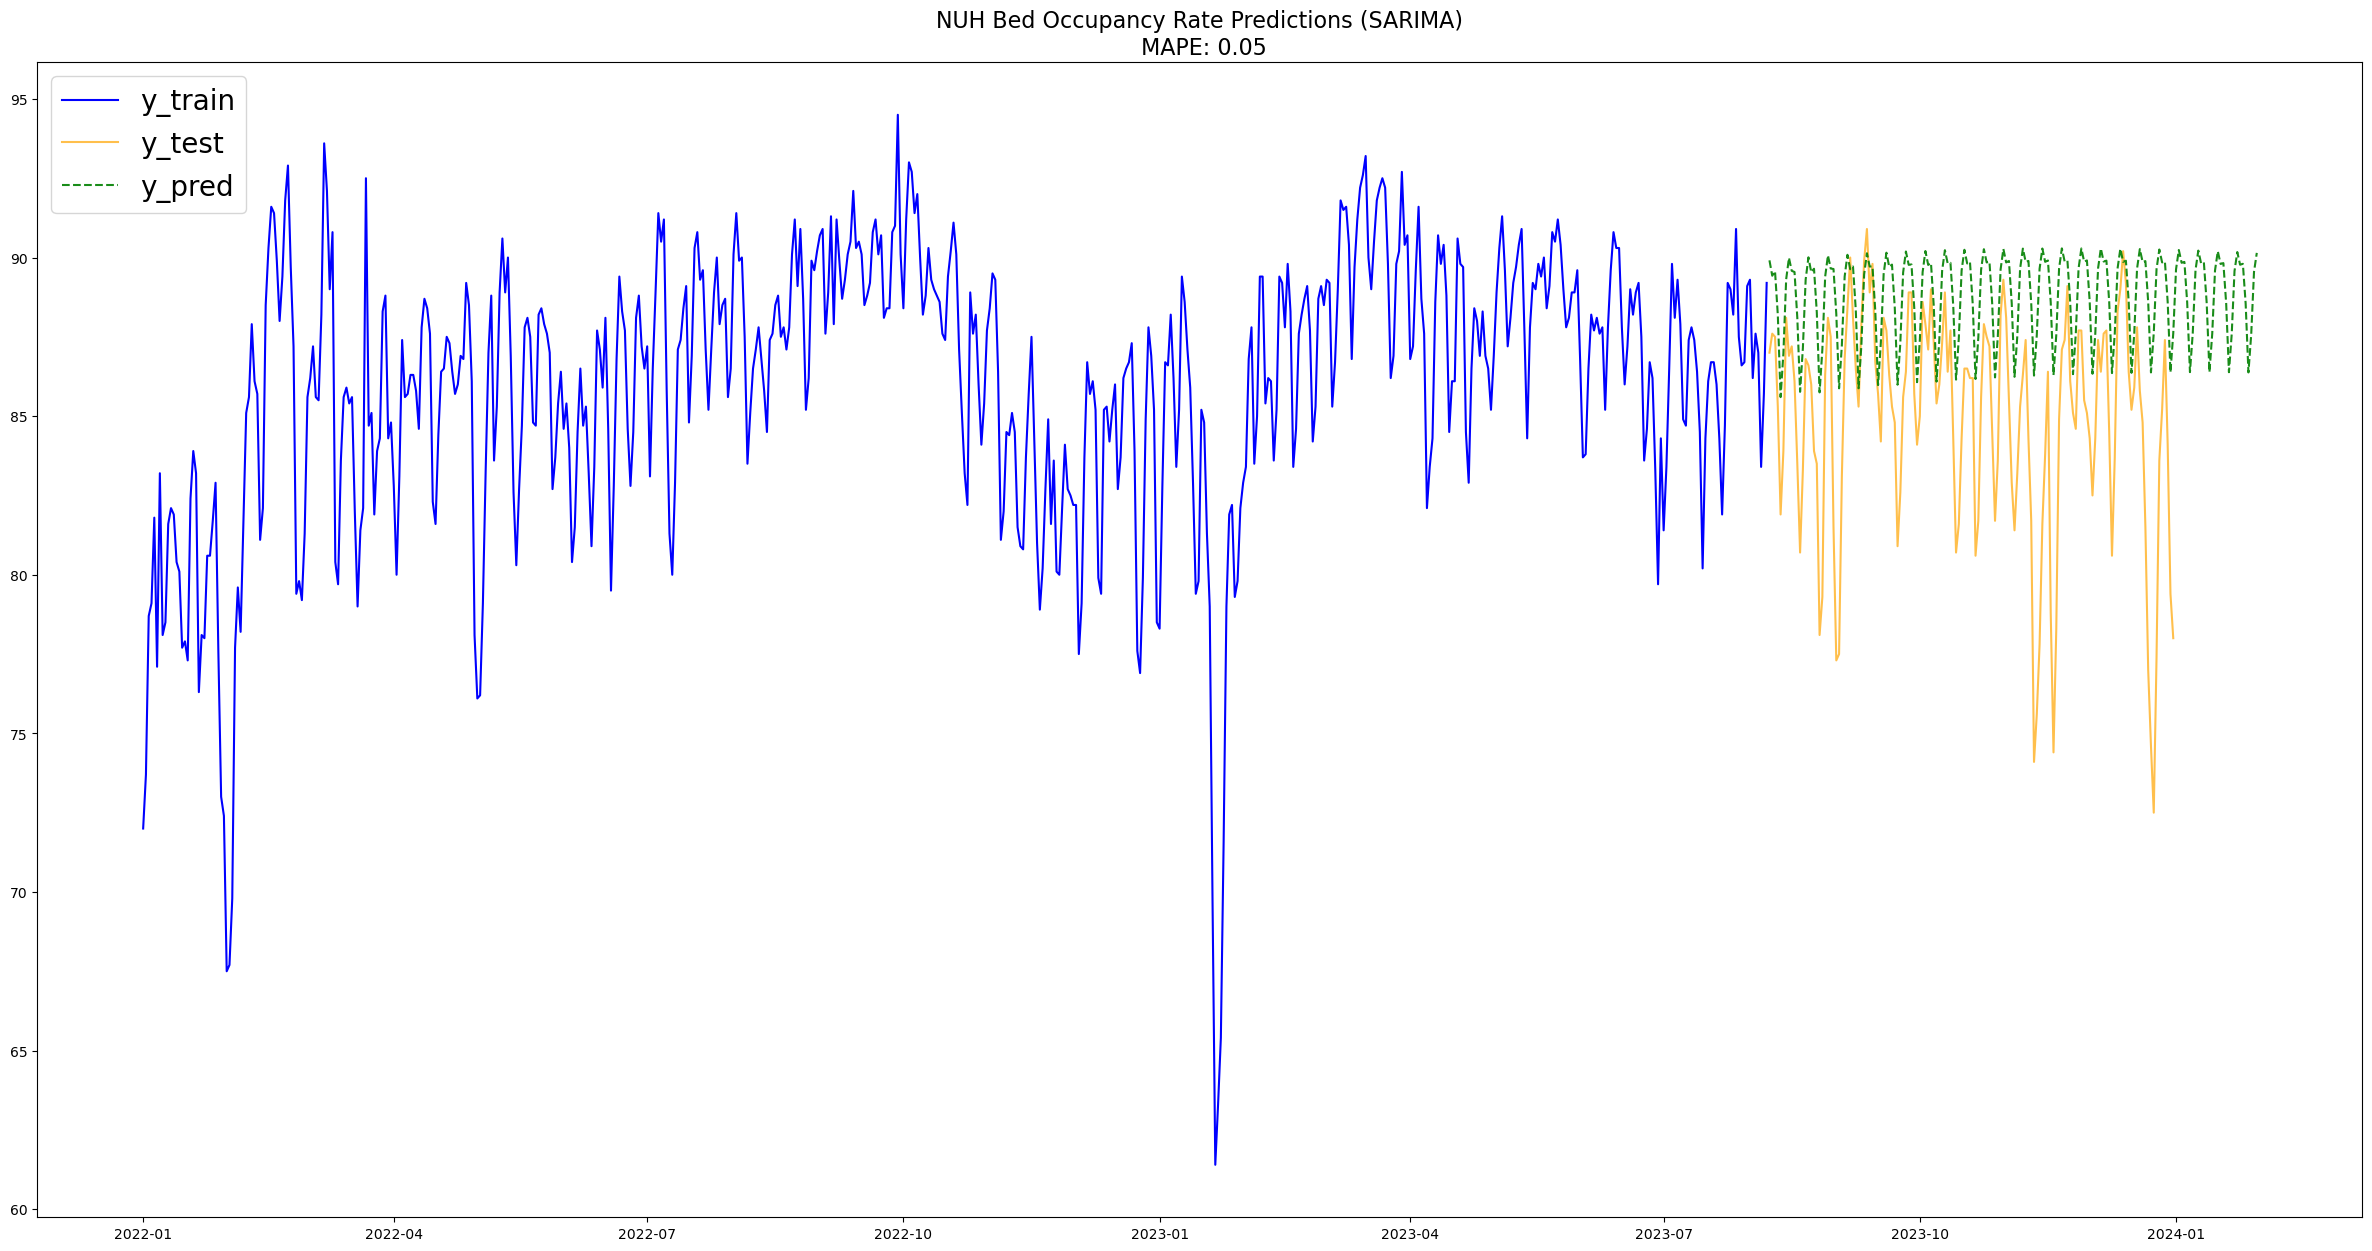

In [12]:
for hospital in hospital_features:
    mape = plot_forecast(hospital_pipes[hospital][2], # y_train
                         hospital_pipes[hospital][3], # y_test
                         hospital_pipes[hospital][4], # sarima model
                         extra_pred_days=30
                        )
    plt.title(label = f'{hospital.upper()} Bed Occupancy Rate Predictions (SARIMA)\n MAPE: {mape:.2f}', fontsize=16)

### Insights
- Predictions of test set matches closely with peaks of the actual test data
- There is a fairly uniform trend, likely a result of the autocorrelation. The trend carries on
even after leaving the test set.
- Optimal hyperparameters are `ARIMA(0,1,0)(2,0,2)[7]` with intercept 